In [1]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings
import scFunctions as sf
import pandas as pd
import pickle
import mygene

%config Completer.use_jedi = False

In [2]:
#Load saved adata object
with open('../data/adata_epi.pickle', 'rb') as f1:
     adata_epi = pickle.load(f1)

In [3]:
df = pd.read_table("../data/mouse_gencode.GRCm38.p6.vM25.basic.annotation.by_gene_id.infercnv_positions.txt", header = None, index_col=0)
df = df.rename(columns={1: 'Chromosome', 2 : "Start", 3 : "End"})


In [4]:
df

,Chromosome,Start,End
0,,,
ENSMUSG00000102693.1,chr1,3073253,3074322
ENSMUSG00000064842.1,chr1,3102016,3102125
ENSMUSG00000051951.5,chr1,3205901,3671498
ENSMUSG00000102851.1,chr1,3252757,3253236
ENSMUSG00000103377.1,chr1,3365731,3368549
...,...,...,...
ENSMUSG00000064368.1,chrM,13552,14070
ENSMUSG00000064369.1,chrM,14071,14139
ENSMUSG00000064370.1,chrM,14145,15288


In [5]:
# Check le nombre de gènes présent dans le jeu de donnée mais pas dans le fichier

liste_gene = df.index

nb_gene = 0
for gene in adata_epi.var.index:
    if gene not in liste_gene:
        nb_gene += 1

print(nb_gene)
print(len(adata_epi.var.index))


## Les gènes écrits sous forme Ensembl il faut les convertir

2569
2569


In [6]:
#Enleve les . dans le nom des transcripts

list_gene = []
for i in range(len(liste_gene)):
    list_gene.append(liste_gene[i].split('.')[0])

# Conversion faite sur le site https://www.biotools.fr/mouse/ensembl_symbol_converter
# Enregistrée dans le fichier mouse_gene.txt dans data

In [7]:
df_gene = pd.read_table("../data/mouse_gene.txt", header = None, index_col=0)
df_gene = df_gene.rename(columns={1: 'Symbol'})
df_gene

,Symbol
0,
ENSMUSG00000102693,4933401J01Rik
ENSMUSG00000064842,Gm26206
ENSMUSG00000051951,Xkr4
ENSMUSG00000102851,Gm18956
ENSMUSG00000103377,Gm37180
...,...
ENSMUSG00000064368,mt-Nd6
ENSMUSG00000064369,mt-Te
ENSMUSG00000064370,mt-Cytb


In [8]:
liste_symbol = [df_gene.loc[i,"Symbol"] for i in list_gene]
df["Symbol"] = liste_symbol
df

,Chromosome,Start,End,Symbol
0,,,,
ENSMUSG00000102693.1,chr1,3073253,3074322,4933401J01Rik
ENSMUSG00000064842.1,chr1,3102016,3102125,Gm26206
ENSMUSG00000051951.5,chr1,3205901,3671498,Xkr4
ENSMUSG00000102851.1,chr1,3252757,3253236,Gm18956
ENSMUSG00000103377.1,chr1,3365731,3368549,Gm37180
...,...,...,...,...
ENSMUSG00000064368.1,chrM,13552,14070,mt-Nd6
ENSMUSG00000064369.1,chrM,14071,14139,mt-Te
ENSMUSG00000064370.1,chrM,14145,15288,mt-Cytb


In [9]:
# Check le nombre de gènes présent dans le jeu de donnée mais pas dans le fichier

liste_gene = df.Symbol.values
remove_list = []
for gene in adata_epi.var.index:
    if gene not in liste_gene:
        remove_list.append(gene)

print(f"{len(remove_list)} gènes non présent dans le fichier mais présent dans le jeu de données soit {round(100 * len(remove_list) / len(adata_epi.var.index), 2)} %")
print(f"Taille du jeu de données : {len(adata_epi.var.index)}")

49 gènes non présent dans le fichier mais présent dans le jeu de données soit 1.91 %
Taille du jeu de données : 2569


In [10]:
to_remove = []

for gene in adata_epi.var.index:
    if gene in remove_list:
        to_remove.append(True)
    else:
        to_remove.append(False) 


adata_epi.var["is_remove"] = to_remove

In [11]:
adata_epi.var

,features,highly_variable,means,dispersions,dispersions_norm,mean,std,is_remove
Rgs20,Rgs20,True,0.207499,-0.233224,1.285322,0.166322,0.264503,False
St18,St18,True,0.032943,0.025962,1.057361,0.023779,0.118785,False
2610203C22Rik,2610203C22Rik,True,0.012992,-0.304456,0.533453,0.010271,0.065258,False
Sgk3,Sgk3,True,0.062788,-0.308872,0.526453,0.050002,0.143926,False
Slco5a1,Slco5a1,True,0.078840,-0.005722,1.007123,0.057785,0.182428,False
...,...,...,...,...,...,...,...,...
Grik1,Grik1,True,0.019657,0.662941,2.067348,0.012891,0.094078,False
Slc22a1,Slc22a1,True,0.043394,-0.044710,0.945303,0.032527,0.129761,False
1700054A03Rik,1700054A03Rik,True,0.018360,0.251532,1.415022,0.013197,0.086066,False
Xlr5a,Xlr5a,True,0.015082,0.356354,1.581227,0.010457,0.080679,False


**On va garder uniquement ces gènes pour faire le InferCNV**

In [12]:
adata_epi_full = adata_epi.copy()

adata_epi = adata_epi_full[:, adata_epi_full.var.is_remove == False]

In [13]:
adata_epi

View of AnnData object with n_obs × n_vars = 9743 × 2520
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population', 'Mouse_ID', 'Week_post Cre_activation', 'Sub_class_Stage', 'Mammary_glands', 'mouse_age_(Week)', 'Stage_old'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'is_remove'
    uns: 'log1p', 'hvg', 'pca', 'Stage_colors', 'neighbors', 'umap', 'orig.ident_colors', 'Population_colors', 'draw_graph', 'diffmap_evals', 'Experiment_ID_colors', 'Stage_old_colors'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [14]:
adata_epi_full

AnnData object with n_obs × n_vars = 9743 × 2569
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population', 'Mouse_ID', 'Week_post Cre_activation', 'Sub_class_Stage', 'Mammary_glands', 'mouse_age_(Week)', 'Stage_old'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'is_remove'
    uns: 'log1p', 'hvg', 'pca', 'Stage_colors', 'neighbors', 'umap', 'orig.ident_colors', 'Population_colors', 'draw_graph', 'diffmap_evals', 'Experiment_ID_colors', 'Stage_old_colors'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

**On a bien enlevé 49 gènes**

Maintenant on va ajouter les loci des gènes dans le jeu de données

In [15]:
df.set_index("Symbol", inplace = True)
# r.join etc car on veut de la forme chr 1 et pas chr1
liste_chr = ['r '.join(str(df.loc[i, "Chromosome"]).split('r')) for i in adata_epi.var.index]
liste_start = [df.loc[i, "Start"] for i in adata_epi.var.index]
liste_end = [df.loc[i, "End"] for i in adata_epi.var.index]

In [16]:
adata_epi.var["chromosome"] = liste_chr
adata_epi.var["start"] = liste_start
adata_epi.var["end"] = liste_end

/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_5193/2925151576.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_epi.var["chromosome"] = liste_chr


In [17]:
adata_epi.var

,features,highly_variable,means,dispersions,dispersions_norm,mean,std,is_remove,chromosome,start,end
Rgs20,Rgs20,True,0.207499,-0.233224,1.285322,0.166322,0.264503,False,chr 1,4909576,5070285
St18,St18,True,0.032943,0.025962,1.057361,0.023779,0.118785,False,chr 1,6487231,6860940
2610203C22Rik,2610203C22Rik,True,0.012992,-0.304456,0.533453,0.010271,0.065258,False,chr 1,9560832,9631175
Sgk3,Sgk3,True,0.062788,-0.308872,0.526453,0.050002,0.143926,False,chr 1,9798107,9900845
Slco5a1,Slco5a1,True,0.078840,-0.005722,1.007123,0.057785,0.182428,False,chr 1,12866549,12992650
...,...,...,...,...,...,...,...,...,...,...,...
Grik1,Grik1,True,0.019657,0.662941,2.067348,0.012891,0.094078,False,chr 16,87895900,88290265
Slc22a1,Slc22a1,True,0.043394,-0.044710,0.945303,0.032527,0.129761,False,chr 17,12648869,12675829
1700054A03Rik,1700054A03Rik,True,0.018360,0.251532,1.415022,0.013197,0.086066,False,chr 19,53033648,53084516
Xlr5a,Xlr5a,True,0.015082,0.356354,1.581227,0.010457,0.080679,False,chr X,73107635,73292976


In [18]:
cnv.tl.infercnv(
    adata_epi,
    reference_key="Stage",
    reference_cat=["Healthy"],
    window_size=250,
)

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs, uns=adata.uns)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


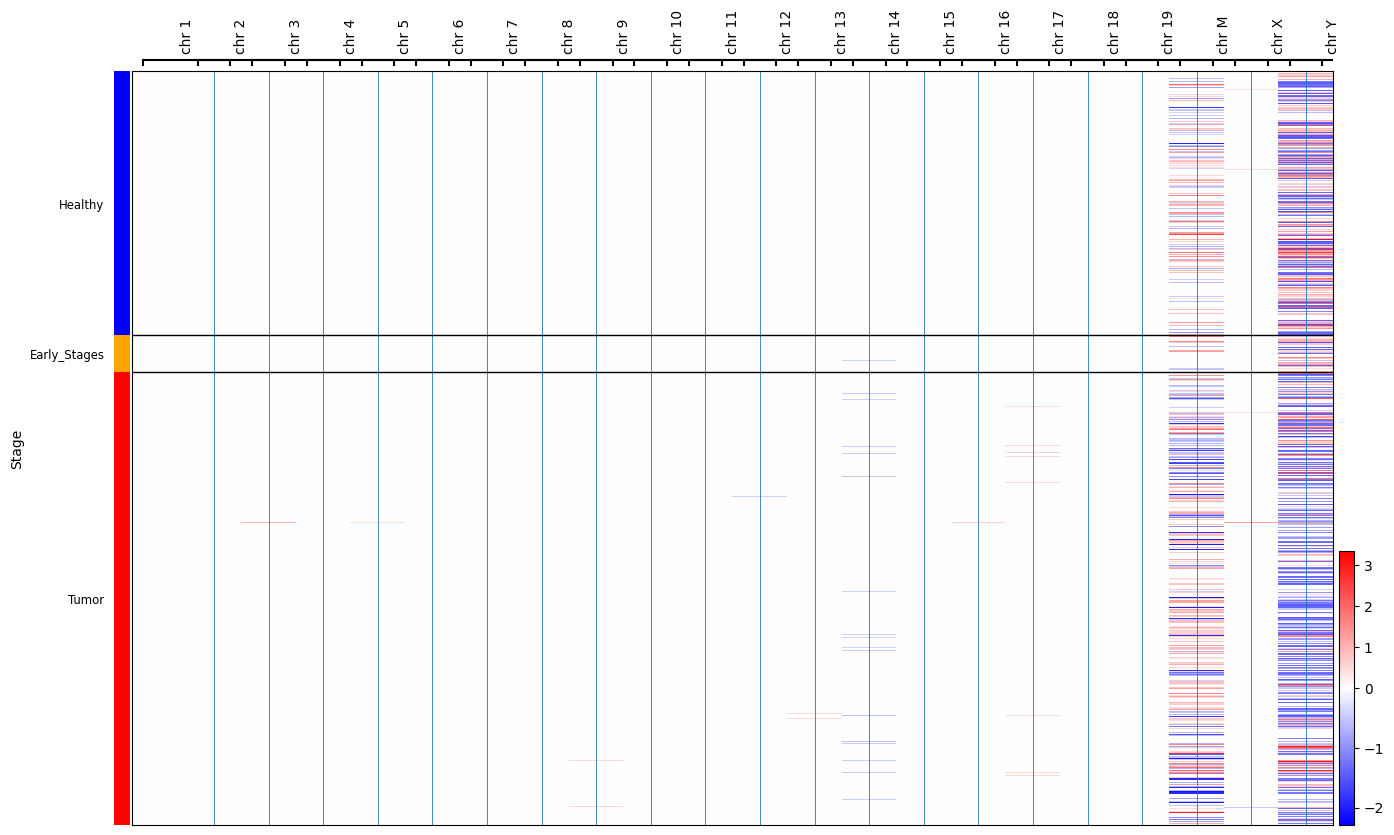

In [19]:
cnv.pl.chromosome_heatmap(adata_epi, groupby="Stage")

Heatmap différente, bizarre je vais voir avec l'autre fichier

In [42]:
#Load saved adata object
with open('../data/adata_epi.pickle', 'rb') as f1:
     adata_epi_full2 = pickle.load(f1)

liste_genes = adata_epi_full2.var.index.values

dico = {}a

with open("../data/Mmgene.out") as fichier:
    lignes = fichier.readlines()
    for ligne in lignes:
        l = ligne.split("\t")
        if l[7] != "GeneName":
            # Dictionnaire de la forme {gene_name : (chr, pstart, pend)}
            dico[l[7]] = tuple([l[8], l[10], l[11]])


In [43]:
j = 0
for i in liste_genes:
    if i not in dico.keys():
        j += 1
        
print(f"Il y a {len(liste_genes)} dans le jeu de données")
print(f"Il y a {len(dico)} dans la base de données")
print(f"Il y a {j} genes présents dans le jeu de données mais pas dans la base de données")

Il y a 2569 dans le jeu de données
Il y a 44352 dans la base de données
Il y a 190 genes présents dans le jeu de données mais pas dans la base de données


In [44]:
liste_global = [] # liste de tuple(name, chr, start, end)

for i in liste_genes:
    try:
        t = (i, dico[i][0], dico[i][1], dico[i][2])
        liste_global.append(t)
        
    except Exception as error:
        liste_global.append((i, "NA", "NA", "NA"))

In [46]:
liste_chromosome = []
liste_start = []
liste_end = []


for i in liste_global:
    liste_chromosome.append(f"chr {i[1]}")
    liste_start.append(i[2])
    liste_end.append(i[3])


adata_epi_full2.var["chromosome"] = liste_chromosome
adata_epi_full2.var["start"] = liste_start
adata_epi_full2.var["end"] = liste_end

In [47]:
adata_epi2 = adata_epi_full2[:,adata_epi_full2.var.chromosome != "NA"]

In [48]:
cnv.tl.infercnv(
    adata_epi2,
    reference_key="Stage",
    reference_cat=["Healthy"],
    window_size=250,
)

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs, uns=adata.uns)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


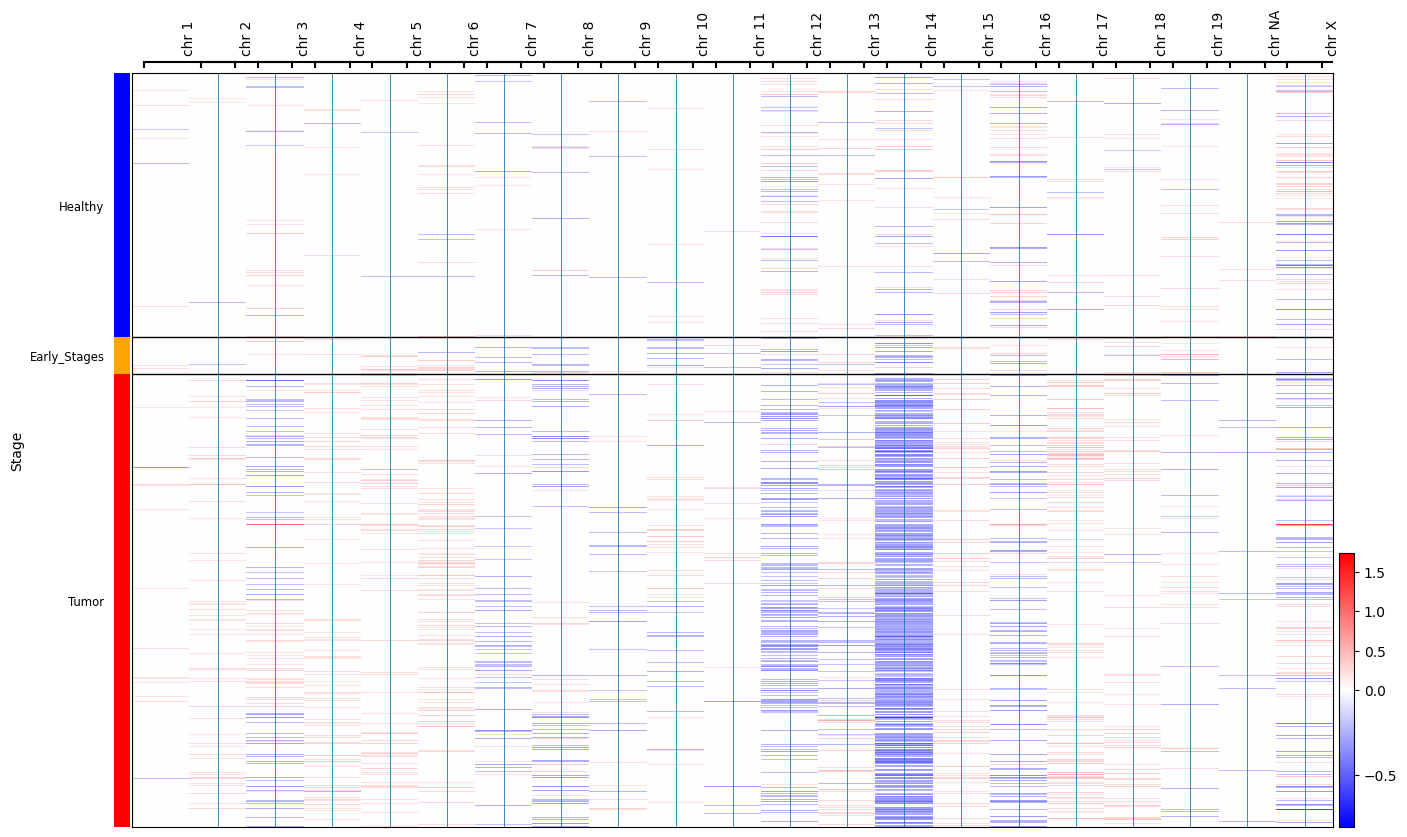

In [49]:
cnv.pl.chromosome_heatmap(adata_epi2, groupby="Stage")

J'ai l'impression que cette annotation est meilleure donc je vais la garder mais c'est pas rassurant de voir que ça dépend du fichier d'annotation

On va essayer de rendre ça mieux en modifiant les paramètres pour avoir un truc similaire à R

**Point important** Il n'y a pas les chromosomes M, X et Y sur R

In [54]:
cnv.tl.infercnv(
    adata_epi,
    reference_key="Stage",
    reference_cat=["Healthy"],
    window_size=250,
    exclude_chromosomes = ('chr X', 'chr Y', 'chr M')
)

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs, uns=adata.uns)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


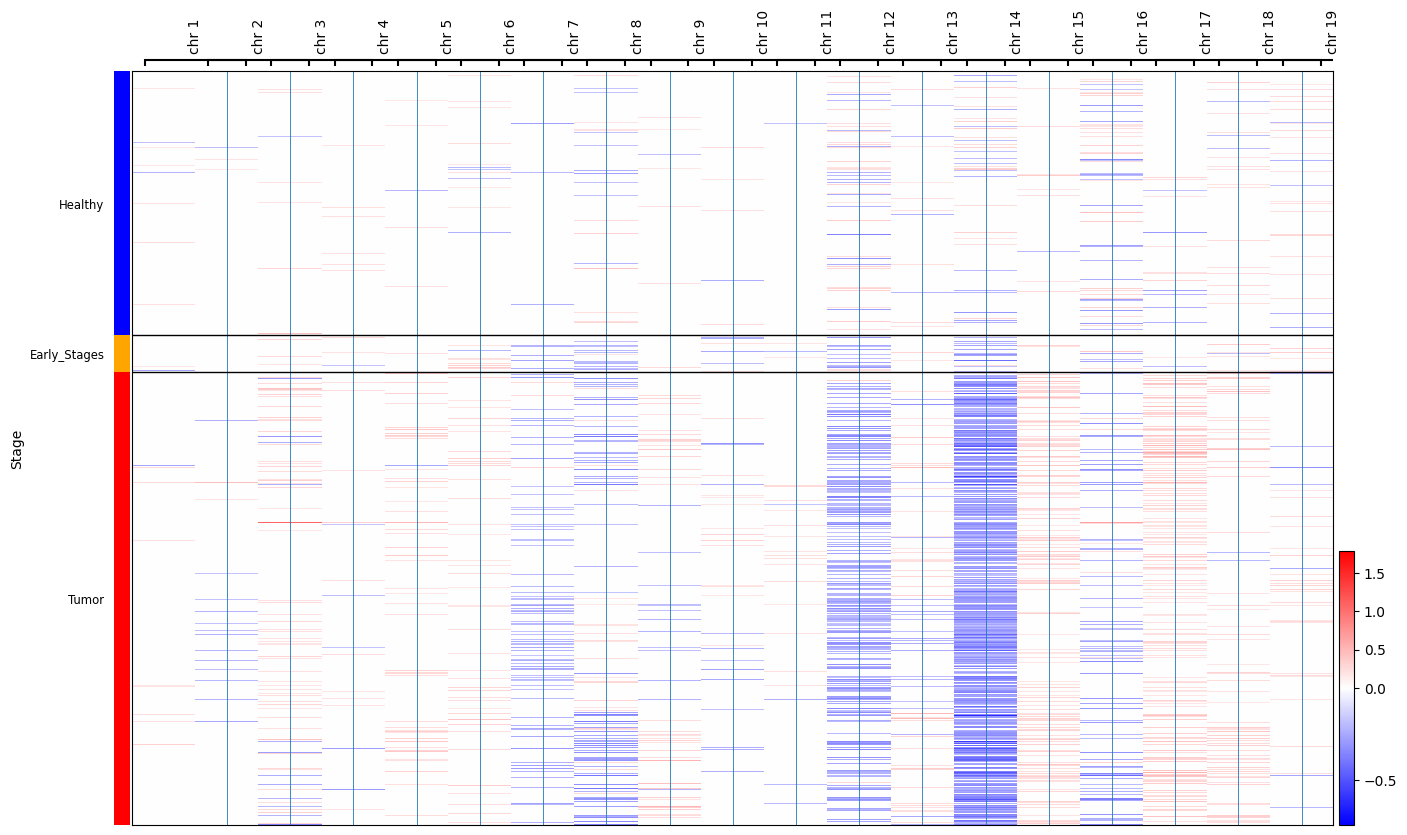

In [55]:
cnv.pl.chromosome_heatmap(adata_epi, groupby="Stage")

Ok ça vient de la, c'est plus clean, on a pas le chr NA

Il semble qu'en prenant en compte le chromosome Y et Mito ça drive tout le signal mais ça doit être pour ça qu'ils sont excluts par défaut

In [138]:
cnv.tl.pca(adata_epi, n_comps = 18)
cnv.pp.neighbors(adata_epi, n_pcs=18)
cnv.tl.leiden(adata_epi, resolution = 0.5)

categories: Healthy, Early_Stages, Tumor
var_group_labels: chr 1, chr 2, chr 3, etc.


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs, uns=adata.uns)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


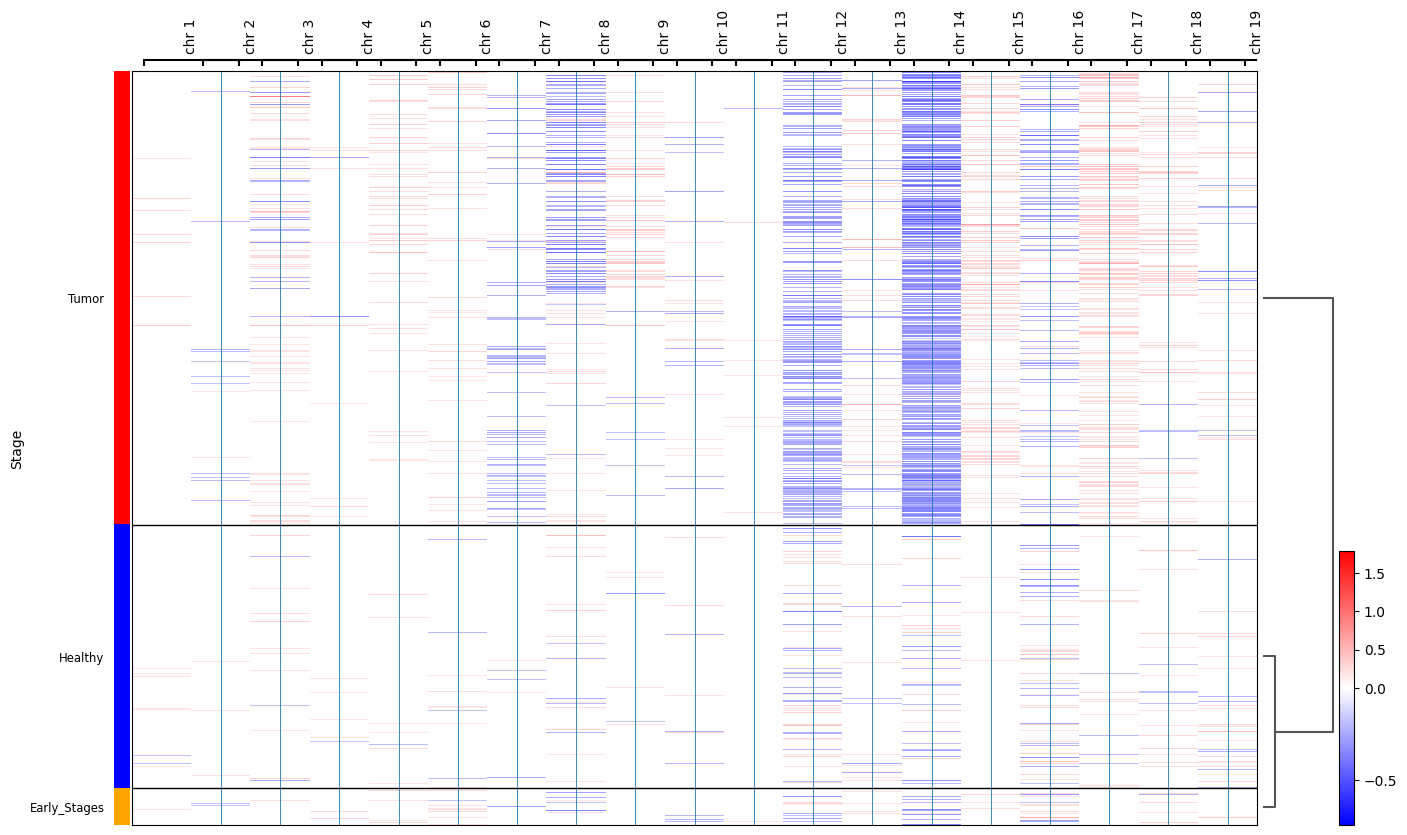

In [147]:
sc.tl.dendrogram(adata_epi, groupby="Stage")
cnv.pl.chromosome_heatmap(adata_epi, groupby="Stage", dendrogram = True)

In [140]:
cnv.tl.umap(adata_epi)
cnv.tl.cnv_score(adata_epi)

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


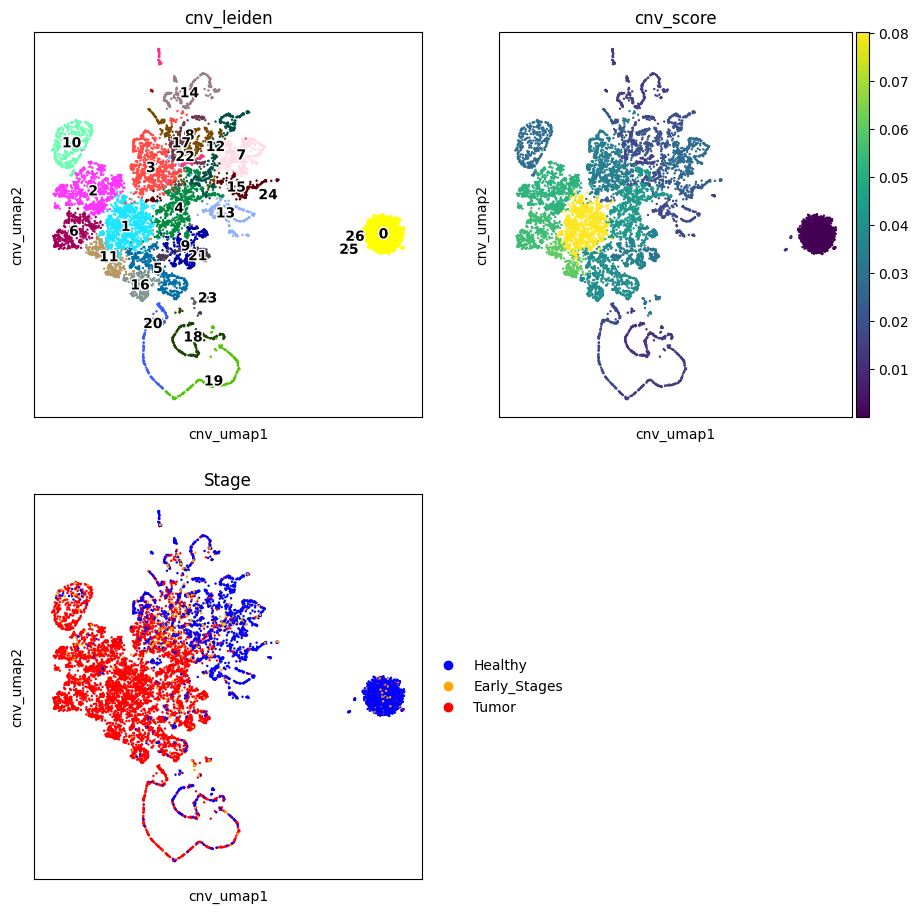

In [141]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata_epi,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata_epi, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata_epi, color="Stage", ax=ax3)

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs, uns=adata.uns)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


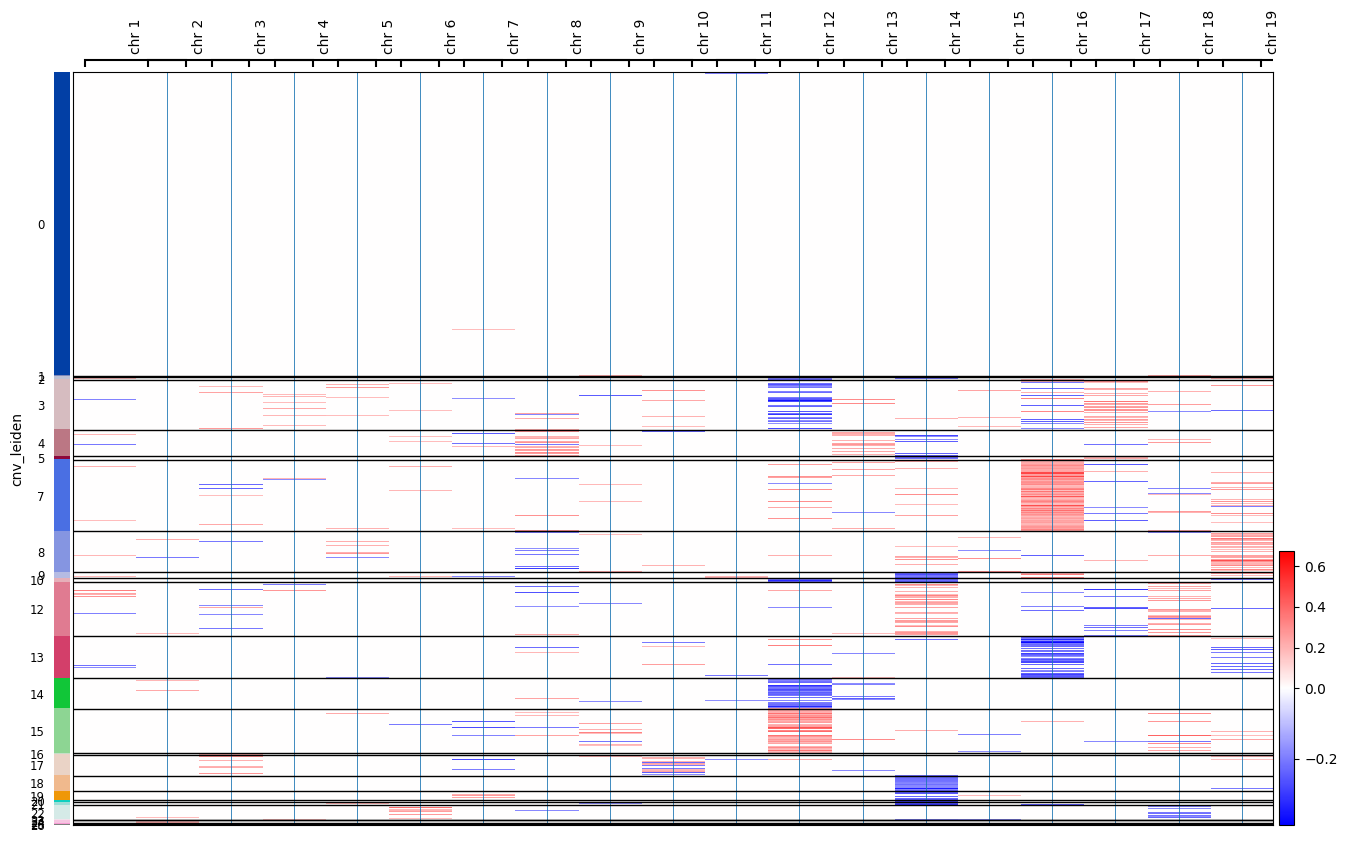

In [142]:
cnv.pl.chromosome_heatmap(adata_epi[adata_epi.obs["Stage"] == "Healthy", :])

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs, uns=adata.uns)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


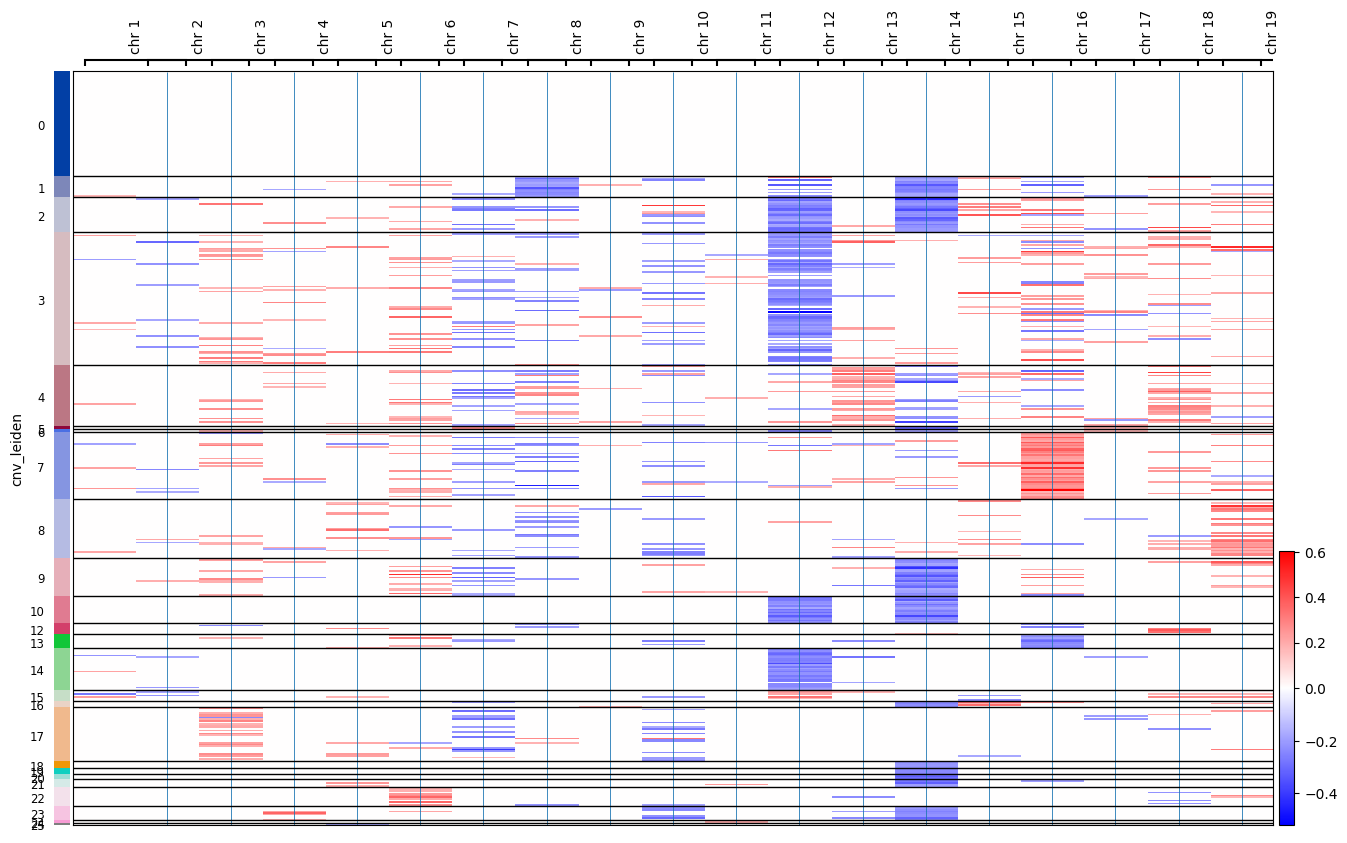

In [143]:
cnv.pl.chromosome_heatmap(adata_epi[adata_epi.obs["Stage"] == "Early_Stages", :])

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs, uns=adata.uns)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


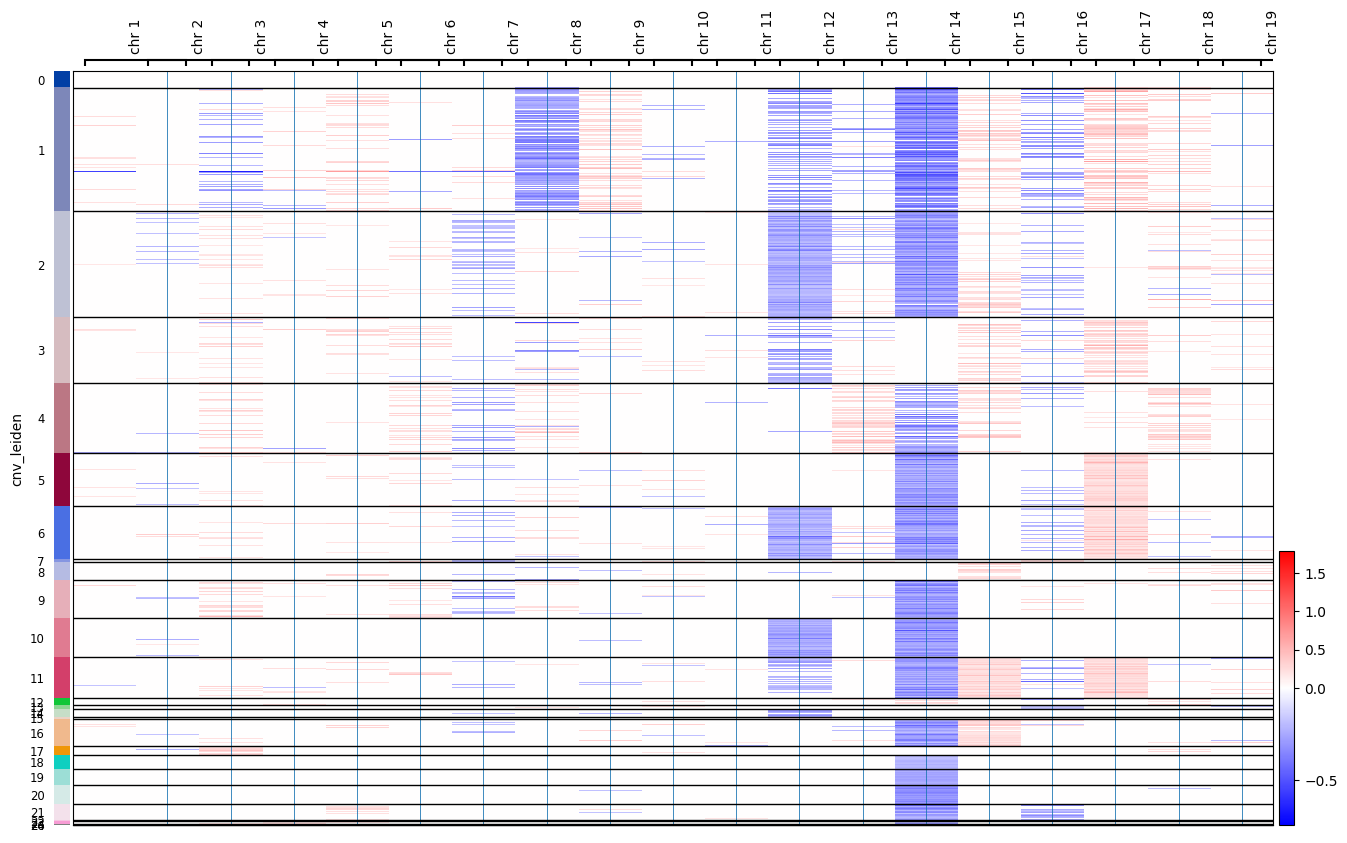

In [144]:
cnv.pl.chromosome_heatmap(adata_epi[adata_epi.obs["Stage"] == "Tumor", :],)